In [1]:
import numpy as np
import os
from skimage.io import imread, imshow, show
from skimage.color import rgb2hsv
import matplotlib.pyplot as plt

# Чтение изображения
data = imread(fname="foodBauman/IMG_20200313_150218.jpg")
# Перевод из RGB в HSV
data_hsv = rgb2hsv(rgb = data)
# Вывод изображения
imshow(data_hsv)
show()

# Обьявление распознаваемых классов
classes = ['cutlet', 'mashed potatoes', 'salad', 'lipton', 'soup', 'julienne']

# Переменная для хранения цветовых признаков
dataset_features = []
# Переменные для обращения к каталогам с изображениями
food_Train = ["foodBauman/Train/"]
food_Test = ["foodBauman/Test/"]

# Функция подготовки цветовых характеристик для блюд
def preparingData(food):
    # В цикле по каталогу
    for food_dir in food:
            # Указание текущей директории
            curr_dir = os.path.join(os.path.sep, food_dir)
            # method getcwd() returns current working directory of a process
            all_imgs = os.listdir(os.getcwd()+curr_dir) # Составляем список из директорий
            # В цикле по изображениям
            for img_file in all_imgs:
                if img_file.endswith(".jpg"): #Ensures reading only JPG files.
                    #Чтение изображения в переменную fruit_data
                    data = imread(fname=os.getcwd()+curr_dir+'\\'+img_file)
                    # Перевод из RGB в HSV
                    data_hsv = rgb2hsv(rgb = data)
                    # Построение гистограммы цветовых характеристик
                    hist = np.histogram(a=data_hsv[:, :, 0], bins=360)
                    # Построение гистограмм
                    plt.bar(np.arange(360), hist[0])
                    plt.show()
                    # Сохранение в мощностей гистограммы в массив 
                    dataset_features.append(hist[0])
    return dataset_features

# Вызов функции и сохранение результата в X_train
X_train = preparingData(food_Train)                

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [2]:
from PIL.ImageDraw import Draw
from PIL import Image, ImageFont
from matplotlib.pyplot import imshow


def draw_bb(img, formatted_outs):
    """Inline draw bounding boxes in output image."""
    
    # Преобразование изображения в формат PIL
    im = Image.fromarray(img)

    # Получение высоты и щирины изображения
    img_width = im.size[0]
    img_height = im.size[1]
    # Загрузка шрифта
    fnt = ImageFont.truetype(font="arial.ttf", size=250)
    # Толщина отрисовки обрамляющего прямоугольника
    thickness = (img_width + img_height) // 300

    # Цикл по tuple от скользящего окна (класс, координаты окна и корреляция)
    for tupl in formatted_outs:
        # Цикл по классам
        for clss in classes:
            # Если найденный класс есть в классах и уже есть в словаре, сохраняем координаты окон
            if (tupl[2] == clss) and (clss in tmp_x.keys()):
                tmp_x[clss].append(tupl[0])
                tmp_y[clss].append(tupl[1])
            # Если найденный класс есть в классах и ещё нет в словаре, сохраняем координаты окон
            elif (tupl[2] == clss) and (clss not in tmp_x.keys()):
                tmp_x[clss] = [tupl[0]]
                tmp_y[clss] = [tupl[1]]
    # По классам
    for clss in classes:
        # Если класс в словаре
        if clss in tmp_x.keys():
            # Формируем обрамляющий прямоугольник по классам
            box = np.min(tmp_y[clss]), np.min(tmp_x[clss]), np.max(tmp_y[clss]), np.max(tmp_x[clss])
            
            # Создаём экземпляр PIL
            draw = Draw(im)

            # Разграничиваем по координатам прямоугольник
            top, left, bottom, right = box
            # Вычисляем координаты для отрисовки текста
            text_origin = (bottom - top)/2, (right - left)/2
            # В цикле по толщине прямоугольника, рисуем прямоугольник
            for idx in range(thickness):
                draw.rectangle([left + idx,
                                top + idx,
                                right - idx,
                                bottom - idx],
                               outline='blue')
            # Отрисовка текста
            draw.text(text_origin, 
                        clss,
                        fill='green', font=fnt, align ="left")
    # Отображение изображения с текстом и обрамляющим прямоугольником
    imshow(np.asarray(im))

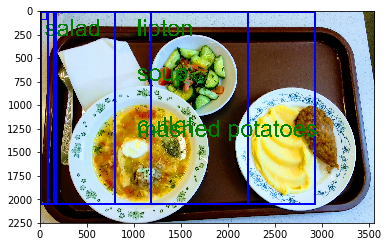

In [16]:
from scipy.stats import pearsonr 

# Реализация скользящего окна
def sliding_window(data):
    corr = [] # корреляция
    window = [] # координаты окна, класс, корреляция
    window_features = [] # цветовые характеристики окна
    # В цикле по ширине изображения
    for x in range(0, data.shape[1] - w_width, stepSize_w):
        # В цикле по высоте изображения
        for y in range(0, data.shape[0] - w_height, stepSize_h):
            # Перевод из RGB в HSV
            data_hsv = rgb2hsv(rgb = data)
            # Проход по окну
            slidingWindow = data_hsv[x:x + w_width, y:y + w_height, :]
            # Построение распределения цветовых характеристик окна
            hist = np.histogram(a=slidingWindow[:, :, 0], bins=360)
            # Сохранение распределения цветовых характеристик окна
            window_features.append(hist[0])
            # В цикле по классу
            for c in range(len(classes)):
                # Вычисление корреляции
                corr.append(pearsonr(X_train[c], window_features[-1])[0])
            # Индекс соответствующий максимальной корреляции
            max_index = np.argmax(corr) % len(classes)
            # Класс и максимальное значение корреляции
            label, correlation = classes[max_index], np.max(corr)
            # Сохранение размеров окна, класса и корреляции
            window.append((x, y, label, correlation))
    
    # Сортировка результата
    window  = sorted(window, key=lambda x: x[-1], reverse=True)
    # Возврат из функции результата
    return window[: int(len(window)* 0.9)]
                            
# Переменная для сохранения результата из функции
images_result = []

# Указание текущей директории
curr_dir = os.path.join(os.path.sep, food_Test[0])
#curr_dir = os.path.join(os.path.sep, 'foodBauman/')
# method getcwd() returns current working directory of a process
all_imgs = os.listdir(os.getcwd()+curr_dir) # Составляем список из директорий
 
# В цикле по изображениям
for img_file in all_imgs:
    # Сохранение координат
    tmp_x = {}
    tmp_y = {}
    images_result.append([])
    
    # В цикле по изображениям
    if img_file.endswith(".jpg"): #Ensures reading only JPG files.
        #Чтение изображения в переменную data
        data = imread(fname=os.getcwd()+curr_dir+'\\'+img_file)
        
        # Вычисление высоты и щирины окна
        w_width, w_height = (data.shape[1]//15, data.shape[0]//15)
        # Размер шага окна
        stepSize_w, stepSize_h = w_width//3, w_height//3
        
        # Результат работы алгоритма
        images_result[-1].append(sliding_window(data))
        
        # По найденным координатам и классам окна
        for window in images_result[-1]: # window = (x, y, label, corr)
            # Отрисовка обрамляющих прямоугольников и классов
            draw_bb(data, window)